## Investigation of Healthcare Facilities Availability in the Toronto Neighborhoods using FourSquare APIs.

#### Data Collection, Cleaning and preparation

##### Import needed Libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


##### A) Toronto Boroughs and Neighborhoods 
The Toronto neighborhood data can be scraped from the wikipedia website

In [3]:
df=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M',header=0)[0]
# Rename some colunms
df.rename(columns={"Postcode": "PostalCode", "Neighbourhood": "Neighborhood"},inplace=True)

# Create filter to use in filtering and removing unwanted rows
filter1=df['Borough']=="Not assigned"
filter2=df['Neighborhood']=="Not assigned"

In [4]:
# Delete unwanted rows
df2=df[~filter1].copy().reset_index(drop=True)

# Replace the "Not assigned" in the column: Neighbourhood, with NaN
df2.Neighborhood.replace("Not assigned",np.nan,inplace=True)

In [5]:
# Replace the missings in the column: Neighbourhood with values in the column: Borough
df2['Neighborhood'].fillna(df2['Borough'],inplace=True)
df2.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [6]:
# Group the postalCode and concatenate all Neighbourhoods in the same PostalCode to form one row
# for each postal code
df3= df2.groupby('PostalCode')['Neighborhood'].apply(', '.join).reset_index()

In [7]:
# Add back the Borough column to the data
df2_sorted=df2.sort_values("PostalCode").copy()
# Remove duplicates
df_NoDuplicates=df2_sorted.drop_duplicates(subset ="PostalCode").copy()
df_NoDuplicates.drop('Neighborhood',axis=1,inplace=True)
df4=df3.merge(df_NoDuplicates, how = "left", on = "PostalCode")
df5=df4.loc[:,['PostalCode','Borough','Neighborhood']]

##### B) Toronto Neighborhoods geography coordinates
This data file is readily available at the following website: http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv

In [10]:
# load the geospacial coordinates dataset
df_longlat=pd.read_csv("http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv")
df_longlat.rename(columns={"Postal Code": "PostalCode"},inplace=True)
df_longlat.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
# Use a Join add the longitudes and lattitudes to the Ontario neighborhoods data
neighborhoods=df5.merge(df_longlat, how = "left", on = "PostalCode")
print("The Ontario neighborhoods dataset now has {} rows and {} columns.".format(
    neighborhoods.shape[0],neighborhoods.shape[1]))
neighborhoods.head()

The Ontario neighborhoods dataset now has 103 rows and 5 columns.


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [12]:
# Subset data to neighborhoods where Borough contain Toronto
#df_Toronto=neighborhoods[neighborhoods['Borough'].str.contains("Toronto")].reset_index().copy()

df_Toronto=neighborhoods.copy()

In [13]:
df_Toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


##### C) Neighborhoods Health Facilities
Use the FourSquare API credentials to scrape the Toronto neighborhood healthcare facilities data

In [14]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20200202' # Foursquare API version
search_query = 'Medical Center'
categoryId = '4bf58dd8d48988d104941735'

In [15]:
LIMIT = 5000 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT, 
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'],
            v['location']['lng'],
            v['location']['formattedAddress'][0],
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Address',
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
# type your answer here

Toronto_venues = getNearbyVenues(names=df_Toronto['Neighborhood'],
                                   latitudes=df_Toronto['Latitude'],
                                   longitudes=df_Toronto['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [17]:
print(Toronto_venues.shape)
Toronto_venues.head()

(4817, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Milner Medical Centre,43.799632,-79.197910,Ontario,Doctor's Office
1,"Rouge, Malvern",43.806686,-79.194353,Medical Centre Family Physicians,43.800811,-79.199986,1152 Morningside Avenue,Medical Center
2,"Rouge, Malvern",43.806686,-79.194353,Appletree Medical Centre,43.769355,-79.184662,4-4218 LAWRENCE AVE E,Medical Center
3,"Rouge, Malvern",43.806686,-79.194353,Medical Building,43.790951,-79.250743,1711 McCowen Road,Medical Center
4,"Rouge, Malvern",43.806686,-79.194353,Malvern Medical Centre,43.808561,-79.219776,1333 Neilson Rd. (at Tapscott),Doctor's Office


In [18]:
# Save a copy of the data
Toronto_venues.to_csv('Toronto_venues.csv')

##### Data Analysis and Presentation of Results

a) What type of Healthcare facilities are available in each neighborhood?

In [19]:
toronto_healthcare_facility_categoris=Toronto_venues['Venue Category'].value_counts().reset_index()
toronto_healthcare_facility_categoris.columns=['Healthcare Facility Category','Count of Facility']
toronto_healthcare_facility_categoris

,Healthcare Facility Category,Count of Facility
0,Doctor's Office,2243
1,Medical Center,2032
2,Medical Lab,169
3,Dentist's Office,169
4,Physical Therapist,46
5,Hospital,45
6,Chiropractor,19
7,Spa,14
8,Alternative Healer,10
9,Mental Health Office,10


In [20]:
toronto_healthcare_facility_categoris.to_csv('toronto_healthcare_facility_categoris.csv')

There are 20 categories of healthcare facilities in the Toronto neighborhood data. This analysis will focus on the top 10 categories.

In [21]:
# Count the number of healthcare facilities by neighborhood.

Facility_counts= pd.crosstab(Toronto_venues.Neighborhood, 
                             Toronto_venues['Venue Category'], 
                             margins=False).reset_index()
del Facility_counts.columns.name
print('This dataset has {} rows and {} columns'.format(
    Facility_counts.shape[0],Facility_counts.shape[1]))


This dataset has 103 rows and 21 columns


In [22]:
# Keep only the columns to work with
Top10_categories=Facility_counts.loc[:,['Neighborhood','Hospital',"Doctor's Office",'Medical Center',
                                        'Medical Lab',"Dentist's Office",'Physical Therapist',
                                        'Chiropractor','Spa','Mental Health Office',
                                        'Alternative Healer']]

#### Top 10 Toronto neighborhoods that have the highest number of hospital
What are the top 10 Toronto neighborhoods that have the highest number of Hospitals?

In [24]:
Top10_categories.sort_values("Hospital", axis = 0, ascending = False, 
                 inplace = True, na_position ='last')

neighborhood_with_hospitals=Top10_categories.head(10).copy().reset_index(drop=True)
neighborhood_with_hospitals=neighborhood_with_hospitals.loc[:,['Neighborhood',"Hospital"]]
neighborhood_with_hospitals.to_csv('neighborhood_with_hospitals.csv')
neighborhood_with_hospitals

,Neighborhood,Hospital
0,"Ryerson, Garden District",3
1,Queen's Park,3
2,Central Bay Street,3
3,"Humber Bay, King's Mill Park, Kingsway Park So...",2
4,"Harbord, University of Toronto",2
5,"Humber Bay Shores, Mimico South, New Toronto",2
6,Church and Wellesley,2
7,"Bedford Park, Lawrence Manor East",1
8,"Brockton, Exhibition Place, Parkdale Village",1
9,Woodbine Heights,1


Central Bay Street, Queen's Park, and Ryerson, Garden District neighborhoods have the highest number of hospitals, with each having three hospitals.

#### Bottom 10 Toronto neighborhoods with the least number of hospital
What are the bottom 10 Toronto neighborhoods that have the least number of Hospitals?

In [82]:
neighborhood_Least_Numb_hospitals=Top10_categories.tail(10).copy().reset_index(drop=True)
neighborhood_Least_Numb_hospitals=neighborhood_Least_Numb_hospitals.loc[:,['Neighborhood',"Hospital"]]
neighborhood_Least_Numb_hospitals

,Neighborhood,Hospital
0,"Flemingdon Park, Don Mills South",0
1,"First Canadian Place, Underground city",0
2,"Fairview, Henry Farm, Oriole",0
3,"Emery, Humberlea",0
4,East Toronto,0
5,"East Birchmount Park, Ionview, Kennedy Park",0
6,Downsview Northwest,0
7,"Dorset Park, Scarborough Town Centre, Wexford ...",0
8,Don Mills North,0
9,York Mills West,0


#### How many neighborhoods do not have any hospital?

In [25]:
filter_No_Hospital=Top10_categories.Hospital==0
No_Hospital=Top10_categories.loc[filter_No_Hospital].copy().reset_index(drop=True)
print('There were {} Neighborhoods that do not have any hospital.'.format(No_Hospital.shape[0]))


There were 68 Neighborhoods that do not have any hospital.


#### Top 10 Toronto neighborhoods that have the highest number of Doctor's Offices
What are the top 10 Toronto neighborhoods that have the highest number of Doctor's Offices?

In [27]:
Top10_categories.sort_values("Doctor's Office", axis = 0, ascending = False, 
                 inplace = True, na_position ='last')

neighborhood_with_Dr_Offices=Top10_categories.head(10).copy().reset_index(drop=True)
neighborhood_with_Dr_Offices=neighborhood_with_Dr_Offices.loc[:,['Neighborhood',"Doctor's Office"]]
neighborhood_with_Dr_Offices.to_csv('neighborhood_with_Dr_Offices.csv')
neighborhood_with_Dr_Offices

,Neighborhood,Doctor's Office
0,"Bathurst Manor, Downsview North, Wilson Heights",28
1,"CFB Toronto, Downsview East",28
2,Willowdale South,28
3,"Emery, Humberlea",28
4,Don Mills North,28
5,"Bedford Park, Lawrence Manor East",28
6,"Flemingdon Park, Don Mills South",28
7,Bayview Village,28
8,York Mills West,27
9,Downsview Central,27


As shown in the table above, eight neighbourhoods have the highest number of doctor's offices with each of them having 28 doctor's offices

#### Bottom 10 Toronto neighborhoods that have the least number of Doctor's Offices
What are the bottom 10 Toronto neighborhoods that have the least number of Doctor's Offices?

In [28]:
neighborhood_least_Dr_Offices=Top10_categories.tail(10).copy().reset_index(drop=True)
neighborhood_least_Dr_Offices=neighborhood_least_Dr_Offices.loc[:,['Neighborhood',"Doctor's Office"]]
neighborhood_least_Dr_Offices

,Neighborhood,Doctor's Office
0,"Humber Bay Shores, Mimico South, New Toronto",17
1,"Chinatown, Grange Park, Kensington Market",17
2,"Parkdale, Roncesvalles",16
3,"Guildwood, Morningside, West Hill",16
4,Northwest,15
5,Humber Summit,14
6,"Rouge, Malvern",14
7,"Highland Creek, Rouge Hill, Port Union",12
8,"Albion Gardens, Beaumond Heights, Humbergate, ...",12
9,Upper Rouge,8


#### Top 10 Toronto neighborhoods that have the highest number of Medical Centers
What are the top 10 Toronto neighborhoods that have the highest number of Medical Centers?

In [29]:
Top10_categories.sort_values("Medical Center", axis = 0, ascending = False, 
                 inplace = True, na_position ='last')

neighborhood_Medical_Center=Top10_categories.head(10).copy().reset_index(drop=True)
neighborhood_Medical_Center=neighborhood_Medical_Center.loc[:,['Neighborhood',"Medical Center"]]
neighborhood_Medical_Center.to_csv('neighborhood_Medical_Center.csv')
neighborhood_Medical_Center

,Neighborhood,Medical Center
0,"The Annex, North Midtown, Yorkville",28
1,"Forest Hill North, Forest Hill West",27
2,"Parkdale, Roncesvalles",27
3,Humewood-Cedarvale,27
4,"Harbord, University of Toronto",27
5,"Harbourfront East, Toronto Islands, Union Station",26
6,"First Canadian Place, Underground city",26
7,"Alderwood, Long Branch",26
8,"Chinatown, Grange Park, Kensington Market",26
9,Christie,26


As shown in the table above, one neighbourhood had the highest number of Medical Centers (29 in number) while two other neighborhoods had 28 Medical Centers each

#### Bottom 10 Toronto neighborhoods that have the least number of Medical Centers
What are the bottom 10 Toronto neighborhoods that have the least number of Medical Centers?

In [30]:
neighborhood_Least_Medical_Center=Top10_categories.tail(10).copy().reset_index(drop=True)
neighborhood_Least_Medical_Center=neighborhood_Least_Medical_Center.loc[:,['Neighborhood',"Medical Center"]]
neighborhood_Least_Medical_Center

,Neighborhood,Medical Center
0,Downsview Central,11
1,"Downsview, North Park, Upwood Park",9
2,Downsview Northwest,9
3,Westmount,8
4,"Emery, Humberlea",7
5,"Rouge, Malvern",7
6,Downsview West,7
7,Upper Rouge,7
8,"Highland Creek, Rouge Hill, Port Union",6
9,Weston,5


#### Top 10 Toronto neighborhoods that have the highest number of Medical Laboratories
What are the top 10 Toronto neighborhoods that have the highest number of medical laboratories?

In [34]:
Top10_categories.sort_values("Medical Lab", axis = 0, ascending = False, 
                 inplace = True, na_position ='last')

neighborhood_with_labs=Top10_categories.head(10).copy().reset_index(drop=True)
neighborhood_with_labs=neighborhood_with_labs.loc[:,['Neighborhood',"Medical Lab"]]
neighborhood_with_labs.to_csv('neighborhood_with_labs.csv')
neighborhood_with_labs

,Neighborhood,Medical Lab
0,Central Bay Street,6
1,"Harbourfront East, Toronto Islands, Union Station",5
2,"First Canadian Place, Underground city",5
3,"Commerce Court, Victoria Hotel",5
4,"Chinatown, Grange Park, Kensington Market",5
5,"Adelaide, King, Richmond",5
6,Queen's Park,5
7,"Design Exchange, Toronto Dominion Centre",5
8,"CN Tower, Bathurst Quay, Island airport, Harbo...",4
9,"Little Portugal, Trinity",4


The Central Bay Street neighborhood has the highest number of medical laboratory (6 in number), followed by five other neighborhoods with 5 medical laboratories each and three other neighborhoods with 4 medical laboratories each.

#### Bottom 10 Toronto neighborhoods that have the least number of Medical Laboratories
What are the bottom 10 Toronto neighborhoods that have the least number of medical laboratories?

In [32]:
neighborhood_least_labs=Top10_categories.tail(10).copy().reset_index(drop=True)
neighborhood_least_labs=neighborhood_least_labs.loc[:,['Neighborhood',"Medical Lab"]]
neighborhood_least_labs

,Neighborhood,Medical Lab
0,Leaside,0
1,"Cliffcrest, Cliffside, Scarborough Village West",0
2,"Bedford Park, Lawrence Manor East",0
3,Lawrence Park,0
4,"CFB Toronto, Downsview East",0
5,"Lawrence Heights, Lawrence Manor",0
6,"Clarks Corners, Sullivan, Tam O'Shanter",0
7,L'Amoreaux West,0
8,Thorncliffe Park,0
9,Weston,0


#### How many neighborhoods do not have any medical laboratory?

In [33]:
filter_No_Medical_Lab=Top10_categories['Medical Lab']==0
Medical_Lab=Top10_categories.loc[filter_No_Medical_Lab].copy().reset_index(drop=True)
print('There were {} Neighborhoods that do not have any Medical Laboratory'.format(Medical_Lab.shape[0]))

There were 28 Neighborhoods that do not have any Medical Laboratory


##### Top 10 Toronto neighborhoods that have the highest number of Dentist's Offices
What are the top 10 Toronto neighborhoods that have the highest number of Dentist's Offices?

In [36]:
Top10_categories.sort_values("Dentist's Office", axis = 0, ascending = False, 
                 inplace = True, na_position ='last')

neighborhood_with_dentist=Top10_categories.head(10).copy().reset_index(drop=True)
neighborhood_with_dentist=neighborhood_with_dentist.loc[:,['Neighborhood',"Dentist's Office"]]
neighborhood_with_dentist.to_csv('neighborhood_with_dentist.csv')
neighborhood_with_dentist

,Neighborhood,Dentist's Office
0,York Mills West,6
1,"Bathurst Manor, Downsview North, Wilson Heights",6
2,Willowdale West,5
3,"Agincourt North, L'Amoreaux East, Milliken, St...",5
4,"Newtonbrook, Willowdale",5
5,Bayview Village,5
6,Willowdale South,5
7,L'Amoreaux West,4
8,"Northwood Park, York University",4
9,Hillcrest Village,4


#### Bottom 10 Toronto neighborhoods that have the least number of Dentist's Office
What are the bottom 10 Toronto neighborhoods that have the least number of Dentist's Offices?

In [91]:
neighborhood_least_dentist=Top10_categories.tail(10).copy().reset_index(drop=True)
neighborhood_least_dentist=neighborhood_least_dentist.loc[:,['Neighborhood',"Dentist's Office"]]
neighborhood_least_dentist

,Neighborhood,Dentist's Office
0,"Humber Bay Shores, Mimico South, New Toronto",0
1,Rosedale,0
2,Christie,0
3,"The Annex, North Midtown, Yorkville",0
4,Downsview Northwest,0
5,"The Danforth West, Riverdale",0
6,"Moore Park, Summerhill East",0
7,"Bloordale Gardens, Eringate, Markland Wood, Ol...",0
8,Leaside,0
9,"Forest Hill North, Forest Hill West",0


#### How many neighborhoods do not have any Dentist's Office?

In [37]:
filter_No_Dentist=Top10_categories["Dentist's Office"]==0
No_Dentist=Top10_categories.loc[filter_No_Dentist].copy().reset_index(drop=True)
print("There were {} Neighborhoods that do not have any Dentist's Office".format(No_Dentist.shape[0]))

There were 20 Neighborhoods that do not have any Dentist's Office


#### What are the top 5 most common facilities in each neighborhood?

In [38]:
# one hot encoding
toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [39]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [40]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0    Medical Center  0.50
1   Doctor's Office  0.36
2       Medical Lab  0.10
3  Dentist's Office  0.02
4          Hospital  0.02


----Agincourt----
              venue  freq
0   Doctor's Office  0.46
1    Medical Center  0.44
2  Dentist's Office  0.04
3      Chiropractor  0.02
4      Optical Shop  0.02


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
              venue  freq
0    Medical Center  0.48
1   Doctor's Office  0.36
2  Dentist's Office  0.10
3     Acupuncturist  0.02
4      Chiropractor  0.02


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
              venue  freq
0    Medical Center  0.43
1   Doctor's Office  0.43
2  Dentist's Office  0.07
3    Massage Studio  0.04
4      Chiropractor  0.04


----Alderwood, Long Branch----
                venue  freq
0      Medical Center  0.52
1     Doctor's Office  0.36
2         Medical L



----Kingsview Village, Martin Grove Gardens, Richview Gardens, St. Phillips----
              venue  freq
0    Medical Center  0.46
1   Doctor's Office  0.46
2      Chiropractor  0.03
3  Dentist's Office  0.03
4       Medical Lab  0.03


----Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor----
                venue  freq
0      Medical Center  0.44
1     Doctor's Office  0.42
2         Medical Lab  0.04
3  Physical Therapist  0.02
4    Dentist's Office  0.02


----L'Amoreaux West----
              venue  freq
0   Doctor's Office  0.48
1    Medical Center  0.44
2  Dentist's Office  0.08
3     Acupuncturist  0.00
4  Maternity Clinic  0.00


----Lawrence Heights, Lawrence Manor----
              venue  freq
0   Doctor's Office  0.55
1    Medical Center  0.37
2  Dentist's Office  0.04
3      Chiropractor  0.02
4          Hospital  0.02


----Lawrence Park----
              venue  freq
0   Doctor's Office  0.48
1    Medical Center  0.44
2  Den

#### What neighborhoods are similar in terms of the top 10 most common healthcare facilities in the neighbourhood?

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted.head(3)

In [43]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 2, 0, 1, 1, 1, 0, 2])

In [44]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_Toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1,Doctor's Office,Medical Center,Optical Shop,Medical Lab,Dentist's Office,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room


#### Create an interactive map to visualize the clusters of neighborhoods that are similar in terms of the availabilty of the top 10 most common healthcare facilities

In [45]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

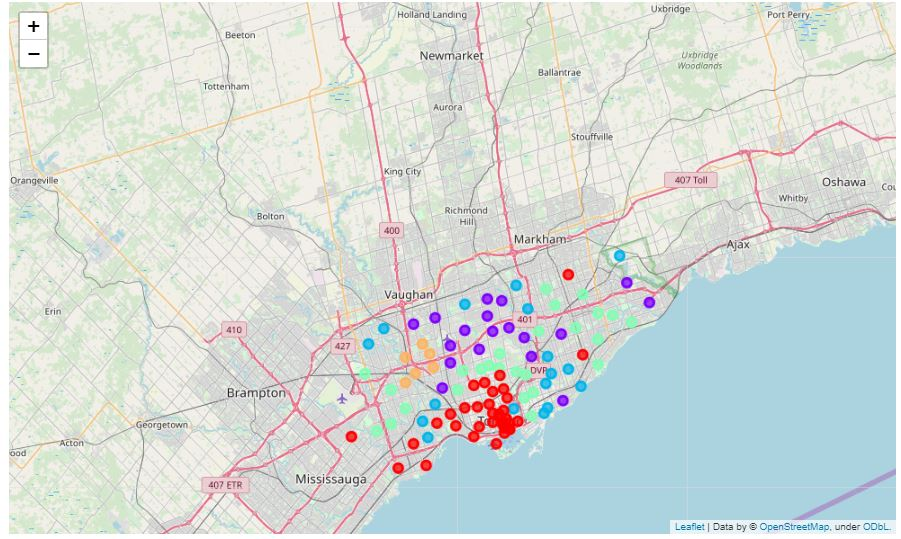

#### Which neighborhoods are grouped together in cluster 1, the cluster with the red colour on the map?

In [47]:
# Cluster 1: colour=Red
Cluster1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(
    range(5, toronto_merged.shape[1]))]]
print("There are {} neighborhoods in cluster 1.".format(Cluster1.shape[0]))
Cluster1

There are 36 neighborhoods in cluster 1.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"East Birchmount Park, Ionview, Kennedy Park",0,Medical Center,Doctor's Office,Dentist's Office,Medical Lab,Rehab Center,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
14,"Agincourt North, L'Amoreaux East, Milliken, St...",0,Medical Center,Doctor's Office,Dentist's Office,Acupuncturist,Optical Shop,Chiropractor,Gym,Alternative Healer,Bank,Emergency Room
47,Davisville,0,Medical Center,Doctor's Office,Physical Therapist,Medical Lab,Dentist's Office,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
48,"Moore Park, Summerhill East",0,Medical Center,Doctor's Office,Physical Therapist,Medical Lab,Gym,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
49,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",0,Medical Center,Doctor's Office,Physical Therapist,Medical Lab,Gym,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
50,Rosedale,0,Medical Center,Doctor's Office,Medical Lab,Physical Therapist,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor,Dentist's Office
52,Church and Wellesley,0,Medical Center,Doctor's Office,Medical Lab,Hospital,Physical Therapist,Dentist's Office,Eye Doctor,Alternative Healer,Bank,Chiropractor
53,Harbourfront,0,Medical Center,Doctor's Office,Medical Lab,Dentist's Office,Physical Therapist,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
54,"Ryerson, Garden District",0,Medical Center,Doctor's Office,Medical Lab,Hospital,Dentist's Office,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
55,St. James Town,0,Medical Center,Doctor's Office,Medical Lab,Dentist's Office,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room


#### Which neighborhoods are grouped together in cluster 2, the cluster with the purple colour on the map?¶

In [48]:
# Cluster 2: colour=Purple
Cluster2=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(
    range(5, toronto_merged.shape[1]))]]
print("There are {} neighborhoods in cluster 2.".format(Cluster2.shape[0]))
Cluster2

There are 18 neighborhoods in cluster 2.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rouge, Malvern",1,Doctor's Office,Medical Center,Optical Shop,Medical Lab,Dentist's Office,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
1,"Highland Creek, Rouge Hill, Port Union",1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
11,"Maryvale, Wexford",1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Rehab Center,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
19,Bayview Village,1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Acupuncturist,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
20,"Silver Hills, York Mills",1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Maternity Clinic,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
21,"Newtonbrook, Willowdale",1,Doctor's Office,Medical Center,Dentist's Office,Hospital,Medical Lab,Acupuncturist,Mental Health Office,Optical Shop,Maternity Clinic,Massage Studio
22,Willowdale South,1,Doctor's Office,Medical Center,Dentist's Office,Acupuncturist,Medical Lab,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
23,York Mills West,1,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Maternity Clinic,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
26,Don Mills North,1,Doctor's Office,Medical Center,Medical Lab,Dentist's Office,Maternity Clinic,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
27,"Flemingdon Park, Don Mills South",1,Doctor's Office,Medical Center,Dentist's Office,Spa,Eye Doctor,Physical Therapist,Medical Lab,Alternative Healer,Bank,Chiropractor


#### Which neighborhoods are grouped together in cluster 3, the cluster with the Blue colour on the map?

In [49]:
# Cluster 3: colour=Blue
Cluster3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(
    range(5, toronto_merged.shape[1]))]]
print("There are {} neighborhoods in cluster 3.".format(Cluster3.shape[0]))
Cluster3

There are 17 neighborhoods in cluster 3.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,"Clairlea, Golden Mile, Oakridge",2,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Rehab Center,Eye Doctor,Alternative Healer,Bank,Chiropractor
9,"Birch Cliff, Cliffside West",2,Doctor's Office,Medical Center,Dentist's Office,Spa,Medical Lab,Rehab Center,Eye Doctor,Alternative Healer,Bank,Chiropractor
16,Upper Rouge,2,Doctor's Office,Medical Center,Acupuncturist,Optical Shop,Chiropractor,Medical Lab,Dentist's Office,Eye Doctor,Alternative Healer,Bank
17,Hillcrest Village,2,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
18,"Fairview, Henry Farm, Oriole",2,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
24,Willowdale West,2,Doctor's Office,Medical Center,Dentist's Office,Hospital,Acupuncturist,Mental Health Office,Medical Lab,Optical Shop,Maternity Clinic,Massage Studio
34,Victoria Village,2,Doctor's Office,Medical Center,Medical Lab,Dentist's Office,Spa,Physical Therapist,Rehab Center,Eye Doctor,Alternative Healer,Bank
35,"Woodbine Gardens, Parkview Hill",2,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Physical Therapist,Rehab Center,Eye Doctor,Alternative Healer,Bank
36,Woodbine Heights,2,Doctor's Office,Medical Center,Dentist's Office,Spa,Medical Lab,Hospital,Physical Therapist,Mental Health Office,Optical Shop,Maternity Clinic
42,"The Beaches West, India Bazaar",2,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Hospital,Physical Therapist,Mental Health Office,Optical Shop,Maternity Clinic


#### Which neighborhoods are grouped together in cluster 4, the cluster with the Green colour on the map?

In [50]:
# Cluster 4: colour=Green
Cluster4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(
    range(5, toronto_merged.shape[1]))]]
print("There are {} neighborhoods in cluster 4.".format(Cluster4.shape[0]))
Cluster4

There are 26 neighborhoods in cluster 4.


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Guildwood, Morningside, West Hill",3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
3,Woburn,3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
4,Cedarbrae,3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
5,Scarborough Village,3,Doctor's Office,Medical Center,Dentist's Office,Rehab Center,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
8,"Cliffcrest, Cliffside, Scarborough Village West",3,Doctor's Office,Medical Center,Dentist's Office,Rehab Center,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room
10,"Dorset Park, Scarborough Town Centre, Wexford ...",3,Doctor's Office,Medical Center,Dentist's Office,Medical Lab,Rehab Center,Spa,Eye Doctor,Alternative Healer,Bank,Chiropractor
12,Agincourt,3,Doctor's Office,Medical Center,Dentist's Office,Optical Shop,Chiropractor,Medical Lab,Spa,Eye Doctor,Alternative Healer,Bank
13,"Clarks Corners, Sullivan, Tam O'Shanter",3,Doctor's Office,Medical Center,Dentist's Office,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room,Eye Doctor
15,L'Amoreaux West,3,Doctor's Office,Medical Center,Dentist's Office,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room,Eye Doctor
25,Parkwoods,3,Doctor's Office,Medical Center,Medical Lab,Dentist's Office,Spa,Gym,Alternative Healer,Bank,Chiropractor,Emergency Room


#### Which neighborhoods are grouped together in cluster 5, the cluster with the Orange colour on the map?

In [51]:
# Cluster 4: colour=Orange
Cluster5=toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(
    range(5, toronto_merged.shape[1]))]]
print("There are {} neighborhoods in cluster 5.".format(Cluster5.shape[0]))
Cluster5

There are 6 neighborhoods in cluster 5.


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,North York,4,Doctor's Office,Medical Center,Hospital,Chiropractor,Dentist's Office,Massage Studio,Gym,Alternative Healer,Bank,Emergency Room
32,North York,4,Doctor's Office,Medical Center,Hospital,Chiropractor,Dentist's Office,Gym,Alternative Healer,Bank,Emergency Room,Eye Doctor
79,North York,4,Doctor's Office,Medical Center,Dentist's Office,Hospital,Chiropractor,Gym,Alternative Healer,Bank,Emergency Room,Eye Doctor
97,North York,4,Doctor's Office,Medical Center,Chiropractor,Dentist's Office,Massage Studio,Spa,Gym,Alternative Healer,Bank,Emergency Room
98,York,4,Doctor's Office,Medical Center,Chiropractor,Dentist's Office,Spa,Gym,Alternative Healer,Bank,Emergency Room,Eye Doctor
99,Etobicoke,4,Doctor's Office,Medical Center,Chiropractor,Dentist's Office,Medical Lab,Spa,Gym,Alternative Healer,Bank,Emergency Room
